# Optimizacion con MAPL

$ G_{i} \leftarrow train(\{(C_{i}^{n}, c_{i}^{n})\}_i) \hspace{1cm}  (\forall n=1,2 ... n\_samples) (\forall i=1,2 ... N_c ) $
 
$ \hspace{5.5cm} LR_n = downsampling(HR_n) $


$ \hspace{5.5cm} C, c \leftarrow mapl(HR_n).C, mapl(LR_n).C$



$ M \leftarrow mapl(Y^{lr}.gtab) $

$ \min_{C^{hr}} \{ \left( \sum_{i}^{Nc} ||GC^{hr} - C^{lr}||^2 \right) + ||C||_{1} \}$


In [2]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mat_utils
#import nibabel as nib
import mapmri.mapmri as mp
#from dipy.core.gradients import gradient_table
import cvxpy as cvx
reload(img_utils)
import load.hcp_img_loader as hcp

Populating the interactive namespace from numpy and matplotlib


In [31]:
def get_sample_dwi(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2):
    # Load Hcp subject
    img, gtab, idxs = loader_func(index, numbers, bval, bvalpos)
    # Downsample data
    lr, _ = img_utils.downsampling(img, scale)
    return img.get_data()[:,:,:, idxs], lr[:,:,:, idxs], gtab

def get_sample(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2):
    """
    # Load Hcp subject
    img, gtab, _ = loader_func(index, numbers, bval, bvalpos)
    # Downsample data
    lr, _ = img_utils.downsampling(img, scale)
    """
    hr, lr, gtab = get_sample_dwi(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2)
    # Calculate MAPL
    C_hr = getC(hr, gtab, radial_order = 4)
    c_lr = getC(lr, gtab, radial_order = 4)
    #del(img)
    del(hr)
    del(lr)
    return C_hr, c_lr, gtab

def get_sample_maker(numbers, loader_func, bval=None, bvalpos=None, scale=2):
    return lambda index : get_sample(index, numbers, loader_func, bval, bvalpos,  scale)

def mm(A, cast_int=True):
    if cast_int :
        return (int(A.min()), int(A.max()))
    else:
        return (A.min(), A.max())
    
def buildT(sample_getter, n_samples):
    C, c, _ = sample_getter(0)
    X = img_utils.column_this(c)
    Y = img_utils.column_this(C)
    for i in range(1, n_samples):
        noised_hr, noised_lr, _ = sample_getter(i)
        X = img_utils.append_column(X, c)
        Y = img_utils.append_column(Y, C)
    return X, Y

def buildT_grouping_by_c(sample_getter, n_samples):
    """
    Genera tantos conjuntos de entrenamiento coef de MAPL
    """
    C, c, _ = sample_getter(0)
    dicX = split_by_coef(c)
    dicY = split_by_coef(C)
    for i in range(1, n_samples):
        C, c, _ = sample_getter(i)
        dicX = split_by_coef(c, dicX)
        dicY = split_by_coef(C, dicY)
    return dicX, dicY

def split_by_coef(img, res=None):
    """
    Dada una imagen separa la cuarta dimension segun su coef de MAPL
    """
    Nc = img.shape[3]
    if res is None:
        res = dict((coef, None) for coef in xrange(Nc))
        
    for c in xrange(Nc):
        XorY = res[c]
        if XorY is None:
            res[c] = img_utils.column_this(img[:,:,:,c])
        else:
            res[c] = img_utils.append_column(XorY, img[:,:,:,c])
    return res

    

## Example of use
#buildT(get_sample_maker(numbers, scale), n_samples)

## Problem definition

$ \min_{C^{hr}} \{ ||GC^{hr} - C^{lr}||^2  + ||C||_{1} \}$


## MapMri

In [74]:
def getC(data, gtab, radial_order = 4):
    Nx, Ny, Nz, Nb = data.shape
    vhr =Nx*Ny*Nz
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    map_model_fit = map_model.fit(data)
    # (Nx, Ny, Nz, Nc)
    C = map_model_fit.mapmri_coeff
    return C

def getMAndU(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    
    # Lapalcian matrix
    laplacian_matrix = mp.mapmri_isotropic_laplacian_reg_matrix(radial_order, 1.)
    laplacian_matrix = laplacian_matrix * mu[0]
    
    return M, laplacian_matrix
    
def getM(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return  M

def get_mapl_params(gtab, radial_order = 4):
    #Fiteo el model
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    # Fiteo la data
    #map_model_fit = map_model.fit(i_hr)
    tau = map_model.tau
    mu = map_model.mu
    print 'mu.shape', mu.shape
    M = getM(radial_order, mu, gtab, tau)
    return M, tau, mu    
    
def get_mapl_params2(gtab, radial_order = 4):
    #Fiteo el model
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    # Fiteo la data
    #map_model_fit = map_model.fit(i_hr)
    tau = map_model.tau
    mu = map_model.mu
    print 'mu.shape', mu.shape, mu
    M, U = getMAndU(radial_order, mu, gtab, tau)
    return M, tau, mu, U    
    

In [83]:
 def define_problem_with_mapl(c_lr, vhr, vlr, G, M, U, tau, gtab, scale):
    _, Nc = M.shape
    
    ## LR volumes
    Clr = c_lr#.reshape((vlr*Nc, 1), order='F')
    
    ## MAPL params
    cvxChr = cvx.Variable(vhr*Nc)
    
    ## Mapl weight
    #betha = cvx.Parameter(value=.23, sign='positive')
    ## Sparcity weight
    alpha = cvx.Parameter(value=1500, sign='positive')
    ## Fidelity weight
    #gamma = cvx.Parameter(value=.62, sign='positive')
    
    # Constraints
    constraints = []
    # constraints = [Yhr >= 0, mapl <= epsilon*vhr*bval]
    #constraints = [Yhr >= 0, Yhr <= i_lr.max()]
    
    cvxG = G
    cvxU = cvx.Constant(U)
    ## Fidelity expression
    fidelity_list = []
    lapace_list = []
    for c in xrange(Nc):
        c_offset_hr = c*vhr
        Chr_c = cvxChr[c_offset_hr:c_offset_hr+vhr]
        Gc = cvx.Constant(G[c])
        Clr_c = cvx.Constant(Clr[c])
        #print 'Gc, Chr_b, Clr', Gc.size,  Chr_c.size , Clr_c.size
        #       Gc:(216:vlr, 1728:vhr) Chr_c:(1728:vhr, 1) Clr_c:(1, 216:vlr)
        fid_b = cvx.sum_squares(Gc*Chr_c - Clr_c.T)
        fidelity_list.append(fid_b)
        
    cvxFidelityExp = sum(fidelity_list)
    
    #Laplacian regularization
    regLaplade_list = []
    vhrc = vhr*Nc
    for voxel in xrange(vhr):
        cvxLapaceReg = cvx.quad_form(cvxChr[voxel:vhrc:vhr], cvxU)
        regLaplade_list.append(cvxLapaceReg)

    cvxLapaceRegExp = sum(regLaplade_list)
    
    #Agregar q M*C es positivo o deberia
    
    # Form objective.
    obj = cvx.Minimize(cvxFidelityExp+alpha*cvx.norm(cvxChr)+cvxLapaceRegExp)#+ 
    
    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    
    return prob, cvxChr 



In [81]:
def solveMin(c_lr, i_hr_shape, G, M, U, tau, gtab, scale=2, max_iters=1500, verbose=False):
    Nx, Ny, Nz, Nb = i_hr_shape
    Nb, Nc = M.shape
    nx, ny, nz = Nx/scale, Ny/scale, Nz/scale 
    vhr, vlr = Nx*Ny*Nz, nx*ny*nz 
    
    prob, cvxChr = define_problem_with_mapl(
                                c_lr, 
                                vhr, 
                                vlr,
                                G, 
                                M, U,tau,
                                gtab,
                                scale)
     
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=0.50e-02, verbose=verbose )  # Returns the optimal value.
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    Nx, Ny, Nz, Nb = i_hr.shape
    Nb, Nc =  M.shape
    
    C = np.asarray(cvxChr.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')

    A = M.dot(C.reshape((Nx*Ny*Nz, Nc), order='F').T).T#mapl_predict(gtab, C.reshape((Nx*Ny*Nz, Nc), order='F'), M, tau, Nx, Ny, Nz)
    A = A.reshape((Nx, Ny, Nz, Nb), order='F')
    
    print 'A.shape', A.shape
    #A = np.asarray(Yhr.value, dtype='float32').reshape(i_hr_shape, order='F')
    
    return A, C, seg, prob


## Solving the problem and cross-validation (leave one out)

In [84]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
reload(e1f)

RES_BASE_FOLDER = './resultados/exp5/'
VMIN, VMAX=-50, 2500

voi_hr_shape = (12, 12, 12, 6)
voi_lr_shape = (6, 6, 6, 6)
#subjects = [100307, 100408, 180129, 180432, 180836, 180937]
subjects = [100307, 100408, 180129]

bvals2000pos = [18, 27, 69, 75, 101, 107]

# Esto es por si quiero alguna S0
#img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])
#i_hr=img.get_data()
#S0 = img_s0.get_data()

reload(hcp)

#print '#Qvals: ', gtab.bvals.shape
#print 'Bvals: ', set(gtab.bvals)
## Con imagenes pequenas multi-shel
loader_func = hcp.load_subject_medium_noS0
sample_maker = get_sample_maker(subjects, loader_func, scale=2)
## Con imagenes pequenas multi-shel
#loader_func = hcp.load_subject_small
#sample_maker = get_sample_maker(subjects, loader_func, scale=2)

n_samples = 3
iterations = 1

# Metrics to save
min_vals_hr_r = []
max_vals_hr_r = []
min_vals_lr_r = []
max_vals_lr_r = []

dif_norm_hrs=[]
dif_norm_lrs=[]    
Yhr_recons_norms=[]
Ylr_recons_norms=[]  
Yhr_norms=[]
Ylr_norms=[]
times = []
optimal_vals = []

## For save results
# base_folder = RES_BASE_FOLDER
## For NOT save results
base_folder = None

for i in range(0, iterations):
    subjects.append(subjects.pop(0))
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject
    
    ## The one that left out to validate
    the_one_out = len(subjects)-1
    i_hr, i_lr, gtab = get_sample_dwi(the_one_out, subjects, loader_func, scale=2)
    #C, c, _ = get_sample(the_one_out, subjects, loader_func, scale=2)
    
    ### Aca shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    lr_samples, hr_samples = buildT_grouping_by_c(sample_maker, n_samples) #lr, hr

    # Build downsampling matrix
    print '= Training and fiting ...'
    regr, chr_train , clr_train, chr_test, clr_test = e1f.train_grouping_by(hr_samples, lr_samples)
    del(chr_train)
    del(clr_train)
    del(chr_test)
    print 'clr_test[0].shape', clr_test[0].shape
    
    G = dict((c,csr_matrix(regr[c].coef_)) for c in regr.keys())
    
    # Mapl params
    M, tau, mu, U = get_mapl_params2(gtab, radial_order = 4)
    print 'U.shape', U.shape
    
    # Minimization solve
    # mock: A, seg = np.ones(i_hr.shape), 20
    print '= Solving optimization problem ...'
    A, C, seg, prob = solveMin(clr_test, i_hr.shape, G, M, U,  tau, gtab, scale=2, max_iters=1500, verbose=True)
    max_vals_hr_r.append(A.max())
    min_vals_hr_r.append(A.min())
    
    ## Recons ^LR

    #max_vals_lr_r.append(B.max())
    #min_vals_lr_r.append(B.min())
    
    # Keep parameters
    print '= Calculating metrics...'
    dif_norm_hr = np.linalg.norm(i_hr-A) # recons-gtrust
    Yhr_norm = np.linalg.norm(i_hr)
    Yhr_recons_norm = np.linalg.norm(A) #recons
    
    #dif_norm_lr = np.linalg.norm(i_lr-B)
    #Ylr_norm = np.linalg.norm(B)
    #Ylr_recons_norm = np.linalg.norm(B)
    
    dif_norm_hrs.append(dif_norm_hr)
    #dif_norm_lrs.append(dif_norm_lr)
    
    Yhr_recons_norms.append(Yhr_recons_norm)
    #Ylr_recons_norms.append(Ylr_recons_norm)
    
    Yhr_norms.append(Yhr_norm)
    #Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = base_folder+ "A/" + 'hrRec_lo' + subject
        np.save(name, A)
        print 'showing hr '+ subject, 'min, max',(A.min(), A.max()) 
        titles=['Reconstruida', 'Original']
        for b in xrange(6):
            plt = img_utils._isc(A, i_hr,b=b ,titles=titles,  vmax=VMAX, vmin=VMIN)
            plt.savefig(name +'b'+str(b)+'.pdf')
        print 'saved A in: ', name + str('.npy')
        
    # Save the B calculated
    if base_folder is not None:
        name = base_folder + 'lrRec_lo' + subject
        np.save(name, B)
        print 'showing lr '+ subject, 'min, max',(B.min(), B.max()) 
        titles=['Reconstruida', 'Original']
        plt = img_utils._isc(B, i_lr, titles=titles,  vmax=VMAX, vmin=VMIN)
        plt.savefig(name + '.pdf')
        print 'saved A in: ', name + str('.npy')
        
    print
    print

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
if base_folder is not None: 
    np.save(base_folder+ 'dif_norm_hrs', dif_norm_hrs)
    #np.save(base_folder+ 'dif_norm_lrs', dif_norm_lrs)
    np.save(base_folder+ 'Yhr_recons_norms', Yhr_recons_norms)
    np.save(base_folder+ 'Ylr_recons_norms', dif_norm_hrs)
    #np.save(base_folder+ 'Yhr_norms', dif_norm_lrs)
    np.save(base_folder+ 'Ylr_norms', Yhr_recons_norms)
    
    np.save(base_folder+ 'max_vals_hr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_hr_r', min_vals_hr_r)
    np.save(base_folder+ 'max_vals_lr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_lr_r', min_vals_hr_r)
    
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)


== Leaving out: # 100307
= Training and fiting ...
clr_test[0].shape (1, 216)
mu.shape (3,) [ 0.00595503  0.00595503  0.00595503]
U.shape (22, 22)
= Solving optimization problem ...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 8843949, CG tol ~ 1/iter^(2.00)
eps = 5.00e-03, alpha = 1.50, max_iters = 1500, normalize = 1, scale = 1.00
Variables n = 41495, constraints m = 87741
Cones:	soc vars: 87741, soc blks: 3479
Setup time: 3.13e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  4.16e-01 
   100| 1.75e

(37, 22)


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

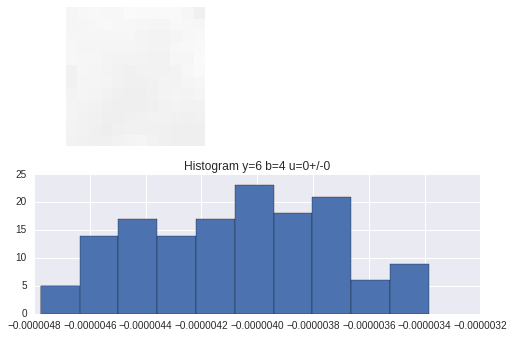

In [106]:
print M.shape
b=4
img_utils._ish(A, b=b, vmin=A.min(), vmax=A.max())

(array([ 144.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

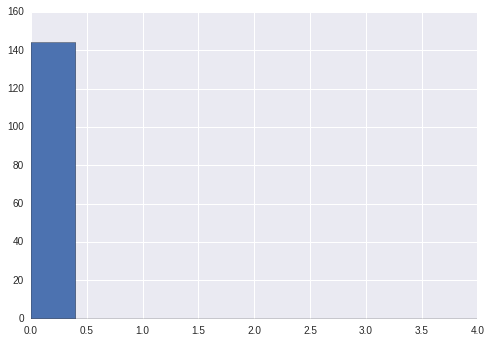

In [69]:
hist(A[:,6,:, b].flatten(), range=(0,4))
#hist(i_hr[:,6,:, b].flatten())

recons (-0.062544631770257125, 0.49218818477166626, 0.94325429811818062)
orig (16.150066, 878.86945, 3105.2488)
con la primer forma de tvnorm
dif_norm_hrs [272614.64023943699]
Yhr_recons_norms [133.24711607398004]
Yhr_norms [272721.56]
times [275.8648359775543]
optimal_vals [29.893633969669693]


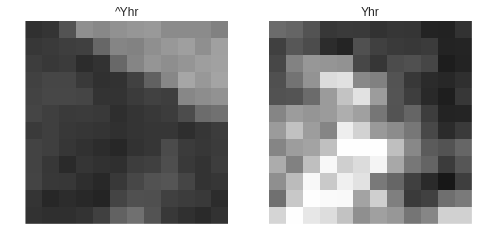

In [65]:
img_utils._isc(A*1000, i_hr, b=b, vmin=0, vmax=1000, titles=['^Yhr', 'Yhr'])

#img_utils._is(A, vmin=A.min(), vmax=A.max())
print 'recons', (A.min(), A.mean(), A.max())
print 'orig',(i_hr.min(), i_hr.mean(), i_hr.max())
#G.shape

print 'con la primer forma de tvnorm'
print 'dif_norm_hrs', dif_norm_hrs
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'times',times
print 'optimal_vals', optimal_vals

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

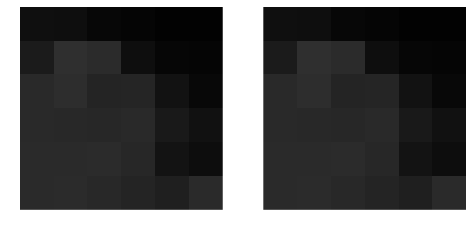

In [8]:
img_utils._isc(B, i_lr, b=4, vmax=max(i_lr.max(), B.max()), vmin=min(i_lr.min(),B.min()))

# HR Testing reconstruction 


mse= 1162428.94935


((0, 0), (119, 1501), (18650, 3072127), 1994760.5223021316)

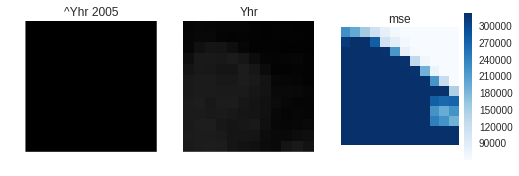

In [54]:
mse = ((A-i_hr)**2).mean(axis=3)
print 'mse=', ((A-i_hr)**2).mean()

bval = 5
titles = ['^Yhr '+str(int(gtab.bvals[bval])), 'Yhr', 'mse']
plt, _, _, im3 = img_utils._isc3(A, i_hr, mse,  b=bval,  vmin=[0, 61104], vmax=[12425, 324973], titles=titles)
plt.colorbar(im3,fraction=0.056, pad=0.04)
mm(A[:,6,:, bval]), mm(i_hr[:,6,:, bval]), mm(mse), mse.mean()+ np.std(mse)

(<Container object of 40 artists>,
 0.89344014176808906,
 0.89014089080400383,
 5.0,
 5.0)

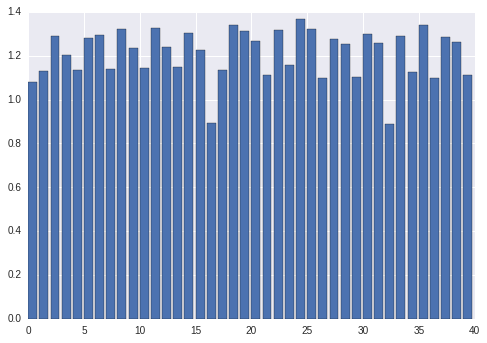

In [23]:
errel = errrel_layers(A, i_hr)
errs =[errel[:,:,:,b].mean() for b in xrange(A.shape[3])]

plt.bar(xrange(A.shape[3]), errs),errs[16], errs[32], gtab.bvals[16], gtab.bvals[32]

# LR Testing reconstruction

$ G*Yhr = Yhr^* $

In [13]:
def errrel_layers(A, B):
    err_rel = np.zeros(A.shape)
    for b in xrange(A.shape[3]):
        err_rel[:,:,:,b] = np.divide(np.abs(A[:,:,:,b]-B[:,:,:,b]), B[:,:,:,b]+0.01)
    return err_rel
    

(6, 6, 6, 6) mse: (0, 22) 0.602017806689 1.4911128861 B: (56, 11659) i_lr: (73, 12425)


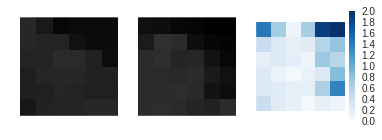

In [212]:
mse_lr = errrel_layers(B,i_lr)
#mse_lr = ((mat_utils.normalize(B)-mat_utils.normalize(i_lr))**2).mean(axis=3)
#mse_lr = ((np.divide(B-i_lr, i_lr))**2).mean(axis=3)
print mse_lr.shape, 'mse:',mm(mse_lr), mse_lr.mean(), np.std(mse_lr), 'B:',mm(B),'i_lr:', mm(i_lr)

reload(img_utils)
plt, _, _, im3 = img_utils._isc3(B, i_lr, mse_lr,  b=4, vmin=[73, 0], vmax=[12000,2],)
plt.colorbar(im3,fraction=0.056, pad=0.04)

# Testing Mapl reconstruction

M.shape (40, 22) C.size 38016
(1728, 40) (12, 12, 12, 40)
(0, 12251)
Error relativo max,min u std (0, 35) 1 1
max/min i_hr: (0, 13620) Eq: (-227, 12707) 1093.13802999


'\nMAPL SALE PAL TRASTE PORQ \nprecisa mas de 6 puntos \n- probar con menos orden \n- probar con minimo 40 puntos y q dios ayude a la compu!!!\n\n'

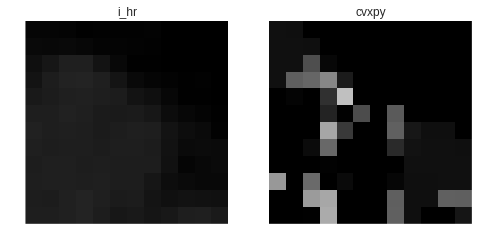

In [33]:
Nx, Ny, Nz, Nb = i_hr.shape
Nb, Nc =  M.shape
Eq_reconst = mapl_predict(gtab, C.reshape((Nx*Ny*Nz, Nc), order='F'), M, tau, Nx, Ny, Nz)


err = np.abs(Eq_reconst - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'cvxpy'])
img_utils._isc(i_hr, Eq_reconst,b=4, vmin=111, vmax=16402, titles=['i_hr', 'cvxpy'])
print 'max/min i_hr:',mm(i_hr),'Eq:', mm(Eq_reconst), Eq_reconst.mean()

"""
MAPL SALE PAL TRASTE PORQ 
precisa mas de 6 puntos 
- probar con menos orden 
- probar con minimo 40 puntos y q dios ayude a la compu!!!

"""


['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'b0_threshold',
 'b0s_mask',
 'big_delta',
 'bvals',
 'bvecs',
 'gradients',
 'info',
 'qvals',
 'small_delta']